C:\Users\HARLAN~1\AppData\Local\Temp/ipykernel_3744/190513012.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


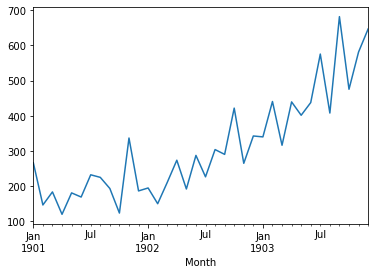

In [1]:
from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
shampoo_sales = read_csv('shampoo_data.txt', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(shampoo_sales.head())
shampoo_sales.plot()
pyplot.show()

# Introduction and some elementary concepts

We can clearly see there is trend in this data, so it's safe to assume the data are non-stationary (note - the presence of a trend does not necessarily imply predictivity!! A time series can have a random walk with a drift term. That is part of the series is predictable as a trend, but part isn't).

Recall our auto-regressive function:

$$y_t = \mu + \rho y_{t-1} + \varepsilon_t$$

As we have already seen, AR processes with $\rho = 1$ have certain special properties, and analysis of trends in financial market predictivity (such as testing the efficient markets hypothesis) rely on determining whether or not this is true. 

(Note that a series can still be a random walk if $\mu \neq 0$. In this case it's just a random walk with drift)

## Unit roots and the Dickey-Fuller test

As it turns out, when there is a stochastic trend in the data, the characteristic roots of the equation are equal to 1. (The full details of this result are unnecessary, but for an intuitive explanation, see this: https://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root)

This is a condition known as a "unit root". As it turns out whenever $\rho = 1$, a unit root is present. So checking for a "unit root" in a time series is really just the same thing as determining whether a series is a random walk or not (i.e. determining if we can confidently say $\rho < 1$).

We can define the **first difference** in the series as $\Delta y_t = y_t - y_{t-1}$. Subtracting the $y_{t-1}$ equation from the first, we get

$$\Delta y_t = [\mu + \rho y_{t-1} + \varepsilon_t] - y_{t-1} = \mu + (\rho - 1)y_{t-1} +\varepsilon_t$$

letting $\theta = (\rho-1)$,  

$$\Delta y_t = \mu + \theta y_{t-1} + \varepsilon_t$$

This is the equation used for the Dickey-Fuller test. Notice we can do normal hypothesis testing on $\theta$ now. And a null hypothesis of $\theta = 0$ is equivalent to $\rho = 1$. So if we can show that $\theta < 0$, this is sufficient to show there is a unit root, and the time-series is a random walk. 

One caveat is that,even though you can use OLS to estimate this equation, we cannot use the usual t-table to determine significance because the error terms do not follow Student's t-distribution. Instead we use a Dickey-Fuller table to determine significance: https://real-statistics.com/statistics-tables/augmented-dickey-fuller-table/. 

## The Augmented Dickey-Fuller (ADF) test

We can add further lags of the data to control for autocorrelation over different time periods in the data. This is the augmented Dickey-Fuller test.

$$\Delta y_t = \mu + \theta y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + ... + \delta_{n} \Delta y_{t-n} +\varepsilon_t$$

The unit root test is the same as before - with the null hypothesis of $\theta = 0$ against the alternative that $\theta < 0$. One downside to this, is that the lag structure of the data must be pre-determined by the researcher (i.e. we have to know how many lags of the data to include). 

## How to know how many lags to include - Information criteria

Knowledge of how many lags to include is ultimately only ever going to be a "best guess", however there are strategies that exist to tease out what are likely the best lag strucutres. The most often used methods are based on information theory (https://en.wikipedia.org/wiki/Information_theory). 

### The Akaike Information Criterion (AIC)

Imagine that we have a statistical model of some data. Let $k$ be the number of estimated parameters of the model, and $L^*$ be the maximized value of the likelihood function for the model. The AIC is given as 

$$AIC = 2k - 2\ln(L^*)$$

The exact value of AIC is generally meaningless. It is only meaningful in relation to the AIC of other candidate models. 

### The Schwarz-Bayes Information Criterion (SBC)*

*(Also known as the Bayes Information Criterion (BIC))

Similar to the AIC, the SBC is given as

$$SBC = k \ln(n) - 2 \ln(L^*)$$

where $n$ is the number of observations. As with the AIC, the exact value of the SBC is generally meaningless. It is only useful in comparison with other models.

# Testing in Python

Let's test this by importing some package information from `statsmodels` which has an ADF test ready for us to use to determine if there's a unit root in the data. You can find the documentation here: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

The ADF test is easy to apply to our shampoo data. The function returns a tuple of the adf test statistic, the p-value, the used lags, the number of observations, the critical values used to determine the p-value, and the maximum value of the information criterion. 

We'll use the option `autolag = 'AIC'` in order to do lag selection.

In [3]:
res = adfuller(shampoo_sales, autolag = 'AIC')

df_stat = res[0]
p_val = res[1]
lags_used = res[2]
n_obs = res[3]
crit_vals = res[4]
max_IC = res[5]

print(f'The DF test statistic is {df_stat}')
print(f'The DF critical values used for hypothesis testing are {crit_vals}')
print(f'The p-value is {p_val}')
print(f'Lags used: {lags_used}')
if p_val < 0.05:
    print('We can reject the hypothesis of theta = 0, so the time series is stationary and there is no unit root.')
else:
    print('We cannot reject the hypothesis that theta = 0, therefore we conclude there is a unit root.')

The DF test statistic is 3.0601420836411815
The DF critical values used for hypothesis testing are {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}
The p-value is 1.0
Lags used: 10
We cannot reject the hypothesis that theta = 0, therefore we conclude there is a unit root.


The p-value in this case is 1.0, so the test is nowhere near rejecting the presence of a random walk, so we can confirm our visual evidence for the data. We conclude that the data is a random walk!

## ADF with trend

If we visually inspect the data one more time, you'll see there is a distinct upward trend in the data. The data can still be a random walk around this trend, but we need to account for it. This can be accomplished by adding a trend term into the ADF test. The new regression equation with a trend term is

$$\Delta y_t = \mu + \beta t + \theta y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + ... + \delta_{n} \Delta y_{t-n} +\varepsilon_t$$

where $\beta$ is the coefficient on the time trend. We can add this to our ADF test by specifying the option `regression = 'ct'` (constant + trend - see the documentation for details here)

In [4]:
res = adfuller(shampoo_sales, autolag = 'AIC', regression = 'ct')

df_stat = res[0]
p_val = res[1]
lags_used = res[2]
n_obs = res[3]
crit_vals = res[4]
max_IC = res[5]

print(f'The DF test statistic is {df_stat}')
print(f'The DF critical values used for hypothesis testing are {crit_vals}')
print(f'The p-value is {p_val}')
print(f'Lags used: {lags_used}')
if p_val < 0.05:
    print('We can reject the hypothesis of theta = 0, so the time series is stationary and there is no unit root.')
else:
    print('We cannot reject the hypothesis that theta = 0, therefore we conclude there is a unit root.')

The DF test statistic is -0.7982228272214204
The DF critical values used for hypothesis testing are {'1%': -4.3749647199999995, '5%': -3.6034675359999997, '10%': -3.23818632}
The p-value is 0.9658319472800336
Lags used: 10
We cannot reject the hypothesis that theta = 0, therefore we conclude there is a unit root.


As we can see even after accounting for the trend in the data, there is still no reason to reject the null hypothesis, so we can continue to conclude there is a unit root in the data.

## Differencing data 

A popular way of treating non-stationarity is to take differences of the data. Simply, unit roots are common in the *levels* of a time series, but they're usually stationary in their *changes*. That is to say for a given time series $y_t$ with a unit root, it is often the case that $\Delta y_t \equiv y_t - y_{t-1}$ does not. Let's difference our shampoo sales data and see if the unit root goes away.

In [6]:
shampoo_diff = shampoo_sales.diff()

Note that when you apply a difference to the data, you'll always lose one observation (there's no way to difference the first observation in the data since there's nothing to precede it). We'll drop this by applying `pd.dropna()`.

In [13]:
shampoo_diff

Month
1901-01-01      NaN
1901-02-01   -120.1
1901-03-01     37.2
1901-04-01    -63.8
1901-05-01     61.0
1901-06-01    -11.8
1901-07-01     63.3
1901-08-01     -7.3
1901-09-01    -31.7
1901-10-01    -69.9
1901-11-01    213.6
1901-12-01   -150.6
1902-01-01      8.4
1902-02-01    -44.8
1902-03-01     60.6
1902-04-01     63.2
1902-05-01    -81.9
1902-06-01     95.6
1902-07-01    -61.0
1902-08-01     77.6
1902-09-01    -13.7
1902-10-01    131.7
1902-11-01   -157.1
1902-12-01     77.8
1903-01-01     -2.6
1903-02-01    100.7
1903-03-01   -124.5
1903-04-01    123.4
1903-05-01    -38.0
1903-06-01     36.1
1903-07-01    138.1
1903-08-01   -167.9
1903-09-01    274.4
1903-10-01   -206.7
1903-11-01    106.0
1903-12-01     65.6
Name: Sales, dtype: float64

In [14]:
shampoo_diff = shampoo_diff.dropna()

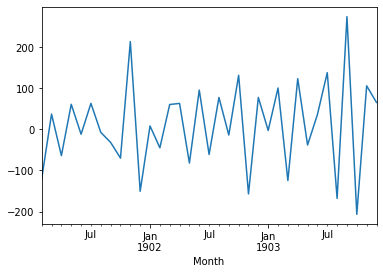

In [15]:
shampoo_diff.plot()
pyplot.show()

As we can see the data appear much more stationary than before. Let's apply the ADF test to see if we can conclude the first difference is stationary.

In [16]:
res = adfuller(shampoo_diff, autolag = 'AIC')

df_stat = res[0]
p_val = res[1]
lags_used = res[2]
n_obs = res[3]
crit_vals = res[4]
max_IC = res[5]

print(f'The DF test statistic is {df_stat}')
print(f'The DF critical values used for hypothesis testing are {crit_vals}')
print(f'The p-value is {p_val}')
print(f'Lags used: {lags_used}')
if p_val < 0.05:
    print('We can reject the hypothesis of theta = 0, so the time series is stationary and there is no unit root.')
else:
    print('We cannot reject the hypothesis that theta = 0, therefore we conclude there is a unit root.')

The DF test statistic is -7.249074055553857
The DF critical values used for hypothesis testing are {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
The p-value is 1.7998574141686703e-10
Lags used: 1
We can reject the hypothesis of theta = 0, so the time series is stationary and there is no unit root.


Great! Even though the original data was non-stationary, we can make it stationary by taking the first difference of the data, that is we're looking at the *changes* in the data through time instead of their levels. It also resulted in a more parsimonious model with only a single lag used to check for the unit root.

## Higher order differencing

In most cases, the first-order difference is enough to induce the data to be stationary. But sometimes data is non-stationary even in its difference. In these cases, it's necessary to take another difference of the data (a difference of differences):

$$\Delta^{\{2\}} y_t = \Delta y_t - \Delta y_{t-1}$$

This is called a *second difference*. One can do even higher order differencing (e.g. third, fourth, and so on...) even further as well. Keep in mind every time you increase the order of differencing, you incur two costs: (1) you continue to lose data in modeling, and more importantly, (2) your data begins to resemble the original time series less and less. If you difference too much - you risk losing all relevance to the original data (this is called "overdifferencing") making your model useless for forecasts.